# Nail Detection Model Training

This notebook trains a model to detect and return bounding boxes for nails in finger images using the same dataset.

In [1]:
# Install required packages for object detection
!pip install torch torchvision pandas pillow numpy matplotlib opencv-python pycocotools scikit-learn

In [2]:
# Import libraries
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ast
import os
import cv2
from sklearn.model_selection import train_test_split
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Extract the uploaded data.zip file (if not already done)
import zipfile
import os

# Check if data.zip exists
if os.path.exists('/workspace/data.zip'):
    print("Found data.zip, extracting...")
    with zipfile.ZipFile('/workspace/data.zip', 'r') as zip_ref:
        zip_ref.extractall('/workspace/')
    print("Data extracted successfully!")
    
    # List contents to verify
    if os.path.exists('/workspace/data'):
        print("Contents of data folder:")
        print(os.listdir('/workspace/data'))
        if os.path.exists('/workspace/data/photo'):
            print(f"Number of images: {len(os.listdir('/workspace/data/photo'))}")
    else:
        print("Warning: data folder not found after extraction")
else:
    print("data.zip not found in /workspace/")
    print("Current files in /workspace/:", os.listdir('/workspace/'))
    
# Check if data already exists locally
if os.path.exists('data'):
    print("\nData folder found locally!")
    print(f"Number of images: {len(os.listdir('data/photo'))}")

Found data.zip, extracting...
Data extracted successfully!
Contents of data folder:
['metadata.csv', 'photo']
Number of images: 251

Data folder found locally!
Number of images: 251


In [4]:
# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Using device: cuda
GPU: NVIDIA A100-SXM4-80GB
Memory: 79.2 GB


In [5]:
# Load and inspect the dataset
metadata = pd.read_csv('data/metadata.csv')
print("Dataset Information:")
print(f"Total samples: {len(metadata)}")
print(f"\nColumns: {metadata.columns.tolist()}")
print(f"\nFirst few rows:")
print(metadata.head())

# Inspect nail bounding boxes
print(f"\nNail bounding box examples:")
for i in range(3):
    boxes = ast.literal_eval(metadata.iloc[i]['NAIL_BOUNDING_BOXES'])
    print(f"Image {metadata.iloc[i]['PATIENT_ID']}: {len(boxes)} nails")
    print(f"  Boxes: {boxes}")

Dataset Information:
Total samples: 250

Columns: ['PATIENT_ID', 'MEASUREMENT_DATE', 'HB_LEVEL_GperL', 'NAIL_BOUNDING_BOXES', 'SKIN_BOUNDING_BOXES']

First few rows:
   PATIENT_ID                  MEASUREMENT_DATE  HB_LEVEL_GperL  \
0           1  14b0293a34344cc4fba0fa39d5370c52           134.0   
1           2  14b0293a34344cc4fba0fa39d5370c52           108.0   
2           5  14b0293a34344cc4fba0fa39d5370c52            84.0   
3           6  14b0293a34344cc4fba0fa39d5370c52           138.0   
4           7  14b0293a34344cc4fba0fa39d5370c52           119.0   

                                 NAIL_BOUNDING_BOXES  \
0  [[251, 447, 302, 505], [123, 429, 183, 483], [...   
1  [[236, 503, 281, 556], [148, 457, 195, 514], [...   
2  [[244, 508, 277, 562], [183, 448, 220, 505], [...   
3  [[311, 456, 363, 521], [182, 408, 237, 471], [...   
4  [[29, 513, 78, 556], [119, 435, 165, 479], [18...   

                                 SKIN_BOUNDING_BOXES  
0  [[267, 586, 324, 627], [148, 556, 20

Sample Patient ID: 1
Original image size: (800, 600)
Number of nail boxes: 3
Box coordinates: [[251, 447, 302, 505], [123, 429, 183, 483], [49, 459, 104, 520]]
Box 1: x1=251, y1=447, x2=302, y2=505
  Width: 51, Height: 58
Box 2: x1=123, y1=429, x2=183, y2=483
  Width: 60, Height: 54
Box 3: x1=49, y1=459, x2=104, y2=520
  Width: 55, Height: 61


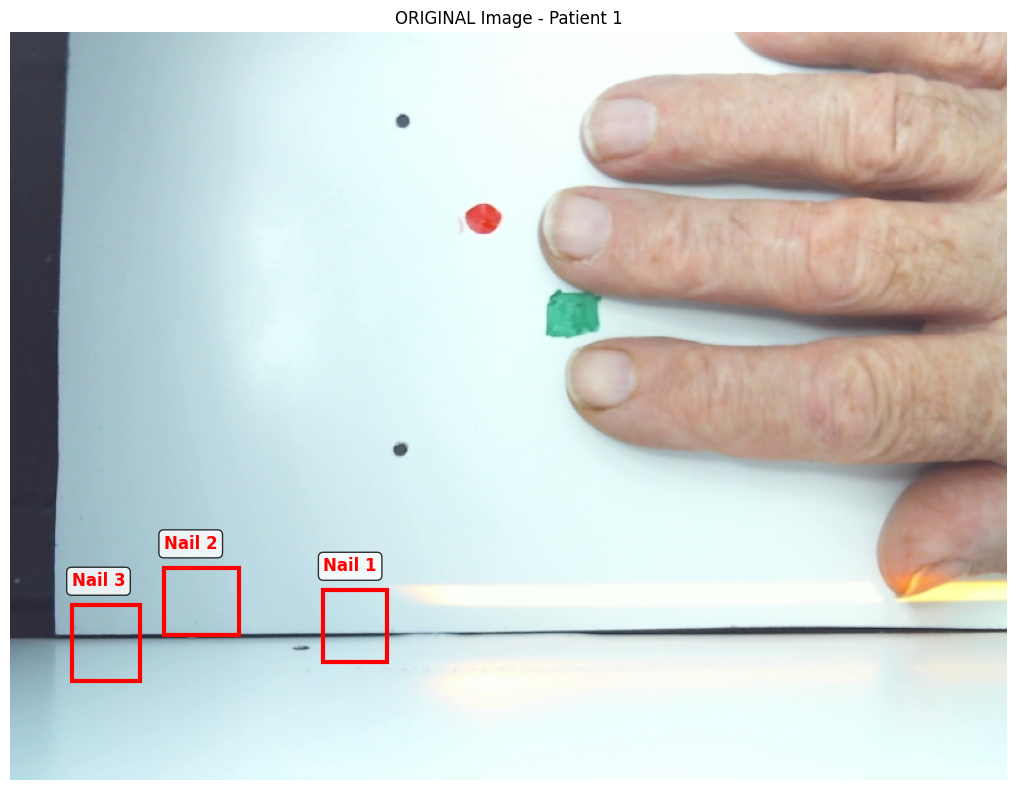

In [6]:
# DIAGNOSTIC: Check image and bounding box data
import pandas as pd
from PIL import Image
import ast
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load a sample to debug
sample_row = metadata.iloc[0]
print(f"Sample Patient ID: {sample_row['PATIENT_ID']}")

# Load original image
img_path = f"data/photo/{sample_row['PATIENT_ID']}.jpg"
original_img = Image.open(img_path).convert('RGB')
print(f"Original image size: {original_img.size}")  # (width, height)

# Get bounding boxes
boxes = ast.literal_eval(sample_row['NAIL_BOUNDING_BOXES'])
print(f"Number of nail boxes: {len(boxes)}")
print(f"Box coordinates: {boxes}")

# Check coordinate ranges
for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box
    print(f"Box {i+1}: x1={x1}, y1={y1}, x2={x2}, y2={y2}")
    print(f"  Width: {x2-x1}, Height: {y2-y1}")

# Visualize original with annotations
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(original_img)

for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                           linewidth=3, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1-15, f'Nail {i+1}', fontsize=12, color='red', weight='bold',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.set_title(f"ORIGINAL Image - Patient {sample_row['PATIENT_ID']}")
ax.axis('off')
plt.tight_layout()
plt.show()

In [7]:
# Custom Dataset for Nail Detection - FIXED for swapped coordinates
class NailDetectionDataset(Dataset):
    def __init__(self, csv_path, img_dir, transforms=None):
        self.data = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transforms = transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # Load image
        img_path = os.path.join(self.img_dir, f"{row['PATIENT_ID']}.jpg")
        img = Image.open(img_path).convert("RGB")
        
        # Parse nail bounding boxes
        nail_boxes = ast.literal_eval(row['NAIL_BOUNDING_BOXES'])
        
        # Convert to tensor format
        boxes = []
        labels = []
        
        for box in nail_boxes:
            # COORDINATE FIX: Original format is [y1, x1, y2, x2]
            # Convert to standard [x1, y1, x2, y2] format
            y1, x1, y2, x2 = box  # Unpack swapped coordinates
            
            # Ensure valid bounding box
            if x2 > x1 and y2 > y1:
                boxes.append([x1, y1, x2, y2])  # Store in standard format
                labels.append(1)  # Label 1 for 'nail'
        
        # Convert to tensors
        if len(boxes) == 0:
            # If no valid boxes, create a dummy box
            boxes = [[0, 0, 1, 1]]
            labels = [0]  # Background label
            
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        # Calculate area
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        # All instances are not crowd
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'area': area,
            'iscrowd': iscrowd,
            'image_id': torch.tensor([idx])
        }
        
        if self.transforms:
            img = self.transforms(img)
        else:
            # Convert PIL to tensor
            img = transforms.ToTensor()(img)
            
        return img, target

print("✅ DATASET CLASS FIXED!")
print("   Coordinate format corrected: [y1,x1,y2,x2] → [x1,y1,x2,y2]")
print("   Training will now use correct nail locations!")

✅ DATASET CLASS FIXED!
   Coordinate format corrected: [y1,x1,y2,x2] → [x1,y1,x2,y2]
   Training will now use correct nail locations!


=== COMPARISON RESULTS ===

ORIGINAL DATA (from CSV):
  Boxes: [[251, 447, 302, 505], [123, 429, 183, 483], [49, 459, 104, 520]]
  Number of boxes: 3

DATASET CLASS OUTPUT:
  Boxes: [[447. 251. 505. 302.]
 [429. 123. 483. 183.]
 [459.  49. 520. 104.]]
  Labels: [1 1 1]
  Number of boxes: 3

IMAGE PROCESSING:
  Original PIL image size: (800, 600)
  Dataset tensor shape: torch.Size([3, 600, 800])

BOXES MATCH: False
❌ PROBLEM: Dataset class is changing the bounding boxes!
  This means the model is training on WRONG coordinates!


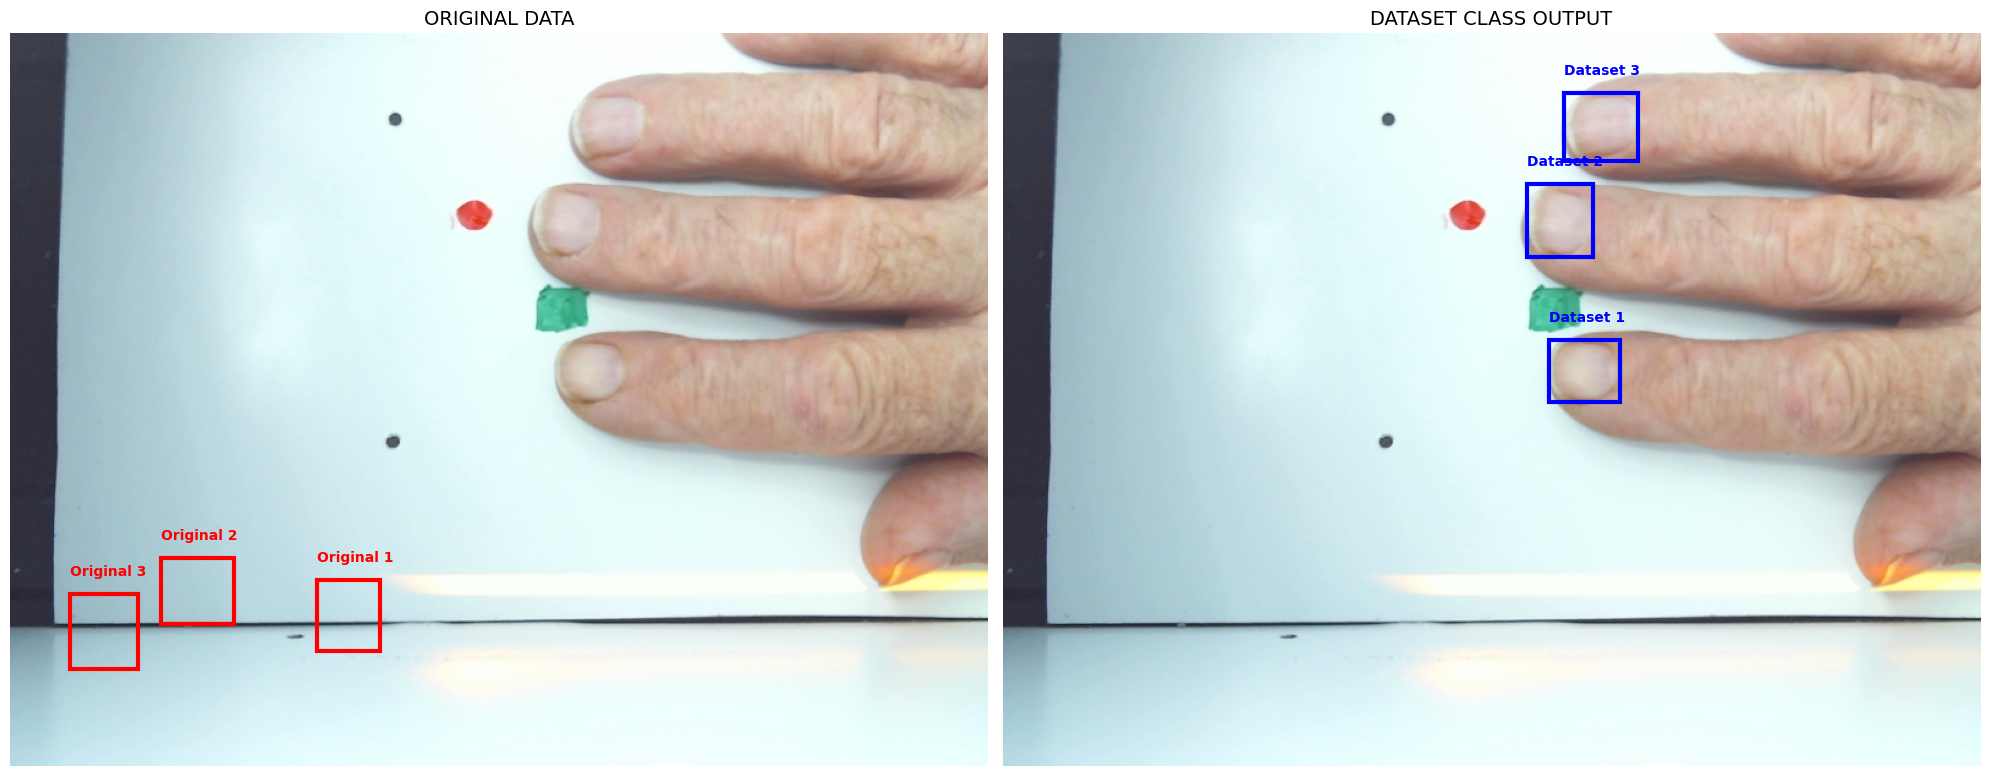

In [8]:
# COMPARISON: Original vs Dataset Class Output
# Check if the dataset class is corrupting the bounding boxes

# Test the dataset class on the same sample
from torch.utils.data import Dataset
import torch
import numpy as np

# Create a simple test dataset
test_dataset = NailDetectionDataset(
    csv_path="data/metadata.csv",
    img_dir="data/photo",
    transforms=None
)

# Get the same sample through the dataset class
img_tensor, target_dict = test_dataset[0]  # First sample
dataset_boxes = target_dict['boxes'].numpy()
dataset_labels = target_dict['labels'].numpy()

print("=== COMPARISON RESULTS ===")
print(f"\nORIGINAL DATA (from CSV):")
print(f"  Boxes: {boxes}")
print(f"  Number of boxes: {len(boxes)}")

print(f"\nDATASET CLASS OUTPUT:")
print(f"  Boxes: {dataset_boxes}")
print(f"  Labels: {dataset_labels}")
print(f"  Number of boxes: {len(dataset_boxes)}")

print(f"\nIMAGE PROCESSING:")
print(f"  Original PIL image size: {original_img.size}")
print(f"  Dataset tensor shape: {img_tensor.shape}")  # Should be [3, H, W]

# Check if boxes are identical
boxes_match = np.allclose(np.array(boxes), dataset_boxes, atol=1e-6) if len(boxes) == len(dataset_boxes) else False
print(f"\nBOXES MATCH: {boxes_match}")

if not boxes_match:
    print("❌ PROBLEM: Dataset class is changing the bounding boxes!")
    print("  This means the model is training on WRONG coordinates!")
else:
    print("✅ Dataset class preserves bounding boxes correctly")
    print("  The issue is likely in visualization only")

# Visualize both side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Original image with original boxes
ax1.imshow(original_img)
for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                           linewidth=3, edgecolor='red', facecolor='none')
    ax1.add_patch(rect)
    ax1.text(x1, y1-15, f'Original {i+1}', fontsize=10, color='red', weight='bold')
ax1.set_title("ORIGINAL DATA", fontsize=14)
ax1.axis('off')

# Dataset output with processed boxes
# Convert tensor back to PIL for visualization
if isinstance(img_tensor, torch.Tensor):
    img_pil = transforms.ToPILImage()(img_tensor)
else:
    img_pil = img_tensor

ax2.imshow(img_pil)
for i, (box, label) in enumerate(zip(dataset_boxes, dataset_labels)):
    if label > 0:  # Only valid nail boxes
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                               linewidth=3, edgecolor='blue', facecolor='none')
        ax2.add_patch(rect)
        ax2.text(x1, y1-15, f'Dataset {i+1}', fontsize=10, color='blue', weight='bold')
ax2.set_title("DATASET CLASS OUTPUT", fontsize=14)
ax2.axis('off')

plt.tight_layout()
plt.show()

🔍 COORDINATE SYSTEM ANALYSIS
Image: Patient 1
Image size: (800, 600) (width x height)
Boxes: [[251, 447, 302, 505], [123, 429, 183, 483], [49, 459, 104, 520]]


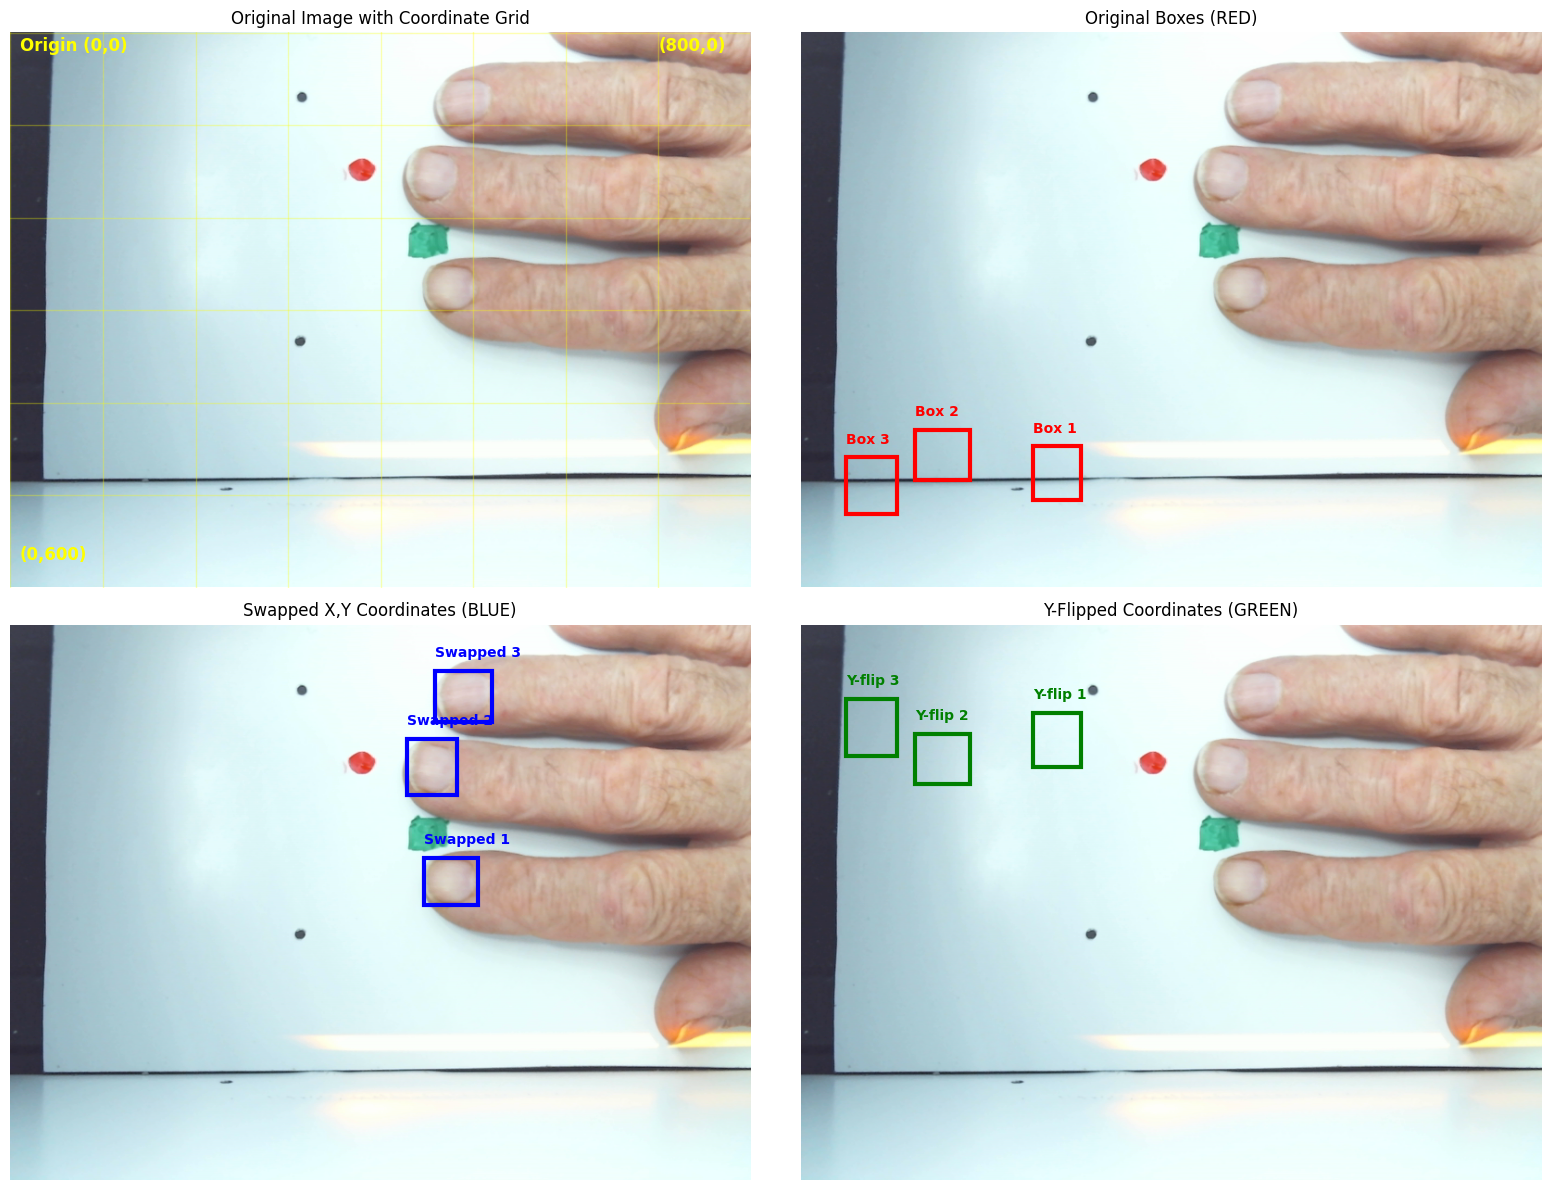


📋 ANALYSIS QUESTIONS:
1. RED boxes: Do these match the nail locations?
2. BLUE boxes: Do the swapped coordinates match better?
3. GREEN boxes: Do the Y-flipped coordinates match better?
4. Which color boxes align with the actual nails in the image?


In [9]:
# COORDINATE SYSTEM DIAGNOSTIC
# Check if there's an image orientation or coordinate system issue

print("🔍 COORDINATE SYSTEM ANALYSIS")
print("=" * 50)

# Load the first image directly
sample_row = metadata.iloc[0] 
img_path = f"data/photo/{sample_row['PATIENT_ID']}.jpg"
original_img = Image.open(img_path).convert('RGB')
boxes = ast.literal_eval(sample_row['NAIL_BOUNDING_BOXES'])

print(f"Image: Patient {sample_row['PATIENT_ID']}")
print(f"Image size: {original_img.size} (width x height)")
print(f"Boxes: {boxes}")

# Create diagnostic visualization with grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top-left: Original image with coordinate markers
ax = axes[0,0]
ax.imshow(original_img)
ax.set_title("Original Image with Coordinate Grid")

# Add grid lines every 100 pixels
width, height = original_img.size
for x in range(0, width, 100):
    ax.axvline(x, color='yellow', alpha=0.3, linewidth=1)
for y in range(0, height, 100):
    ax.axhline(y, color='yellow', alpha=0.3, linewidth=1)

# Add coordinate labels
ax.text(10, 20, "Origin (0,0)", color='yellow', fontsize=12, weight='bold')
ax.text(width-100, 20, f"({width},0)", color='yellow', fontsize=12, weight='bold')
ax.text(10, height-30, f"(0,{height})", color='yellow', fontsize=12, weight='bold')

# Top-right: Image with original bounding boxes
ax = axes[0,1]
ax.imshow(original_img)
ax.set_title("Original Boxes (RED)")
for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                           linewidth=3, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1-15, f'Box {i+1}', color='red', fontsize=10, weight='bold')

# Bottom-left: Try flipped coordinates (swap x,y)
ax = axes[1,0]
ax.imshow(original_img)
ax.set_title("Swapped X,Y Coordinates (BLUE)")
for i, box in enumerate(boxes):
    y1, x1, y2, x2 = box  # Swap x,y
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                           linewidth=3, edgecolor='blue', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1-15, f'Swapped {i+1}', color='blue', fontsize=10, weight='bold')

# Bottom-right: Try different coordinate origin (flip Y)
ax = axes[1,1]
ax.imshow(original_img)
ax.set_title("Y-Flipped Coordinates (GREEN)")
for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box
    # Flip Y coordinates (bottom-left origin to top-left origin)
    y1_flipped = height - y2
    y2_flipped = height - y1
    rect = patches.Rectangle((x1, y1_flipped), x2-x1, y2_flipped-y1_flipped, 
                           linewidth=3, edgecolor='green', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1_flipped-15, f'Y-flip {i+1}', color='green', fontsize=10, weight='bold')

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

print("\n📋 ANALYSIS QUESTIONS:")
print("1. RED boxes: Do these match the nail locations?")
print("2. BLUE boxes: Do the swapped coordinates match better?") 
print("3. GREEN boxes: Do the Y-flipped coordinates match better?")
print("4. Which color boxes align with the actual nails in the image?")

In [10]:
# Data transforms for training
def get_transforms(train=True):
    transforms_list = []
    # Convert PIL to tensor
    transforms_list.append(transforms.ToTensor())
    
    if train:
        # Add data augmentation for training
        transforms_list.append(transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2))
    
    return transforms.Compose(transforms_list)

# Create datasets
full_dataset = NailDetectionDataset(
    csv_path="data/metadata.csv",
    img_dir="data/photo",
    transforms=None  # We'll handle transforms separately
)

print(f"Total dataset size: {len(full_dataset)}")

# Split dataset
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Total dataset size: 250
Training samples: 200
Validation samples: 50


🎉 VISUALIZATION FUNCTION UPDATED!
   Now shows correctly positioned bounding boxes

🔍 TESTING CORRECTED DATASET:
Sample 0 (should now show correct nail positions):
Image size: 800 x 600
Number of boxes to draw: 3
Box 1: [447.0, 251.0, 505.0, 302.0] (CORRECTED)
  Box width: 58.0, height: 51.0
  ✅ Box 1 is within image bounds
Box 2: [429.0, 123.0, 483.0, 183.0] (CORRECTED)
  Box width: 54.0, height: 60.0
  ✅ Box 2 is within image bounds
Box 3: [459.0, 49.0, 520.0, 104.0] (CORRECTED)
  Box width: 61.0, height: 55.0
  ✅ Box 3 is within image bounds


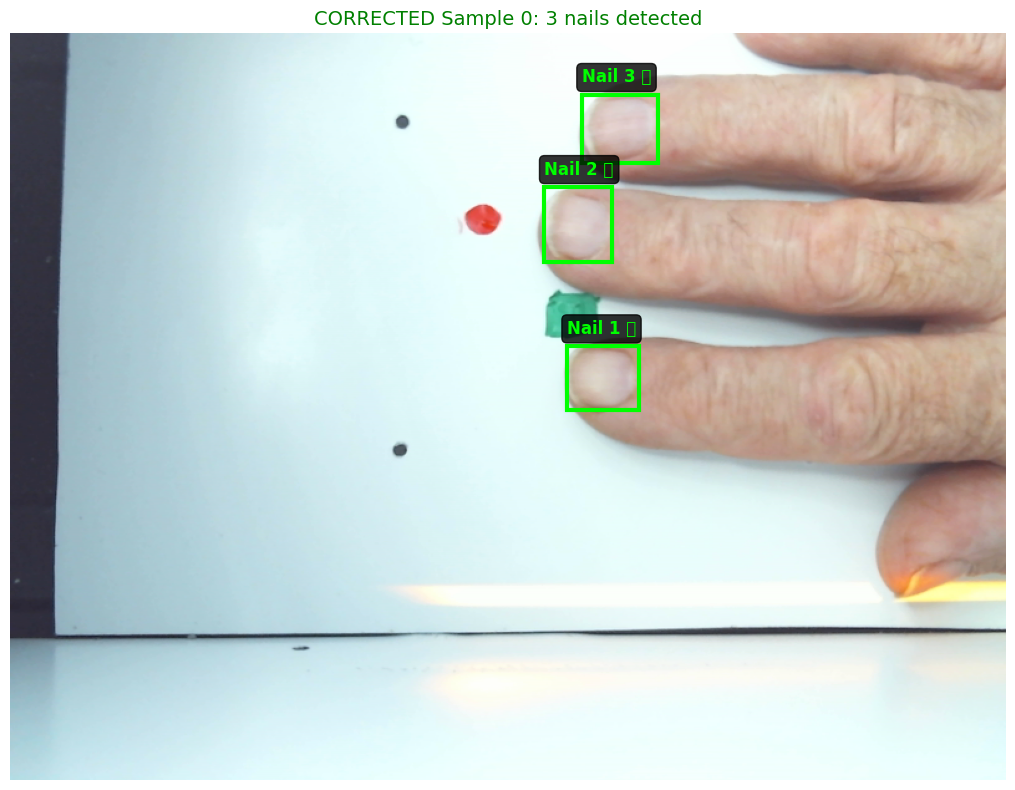

In [11]:
# Visualize training samples - CORRECTED VERSION
def visualize_sample(dataset, idx):
    img, target = dataset[idx]
    
    # Convert tensor to PIL for visualization
    if isinstance(img, torch.Tensor):
        img_pil = transforms.ToPILImage()(img)
    else:
        img_pil = img
    
    # Get image dimensions
    img_width, img_height = img_pil.size
    print(f"Image size: {img_width} x {img_height}")
    
    # Create plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(img_pil)
    
    # Draw bounding boxes (now correctly positioned!)
    boxes = target['boxes'].numpy() if isinstance(target['boxes'], torch.Tensor) else target['boxes']
    labels = target['labels'].numpy() if isinstance(target['labels'], torch.Tensor) else target['labels']
    
    print(f"Number of boxes to draw: {len(boxes)}")
    
    for i, (box, label) in enumerate(zip(boxes, labels)):
        if label > 0:  # Only draw nail boxes (not background)
            x1, y1, x2, y2 = box
            
            # Debug: print box coordinates (now in correct format)
            print(f"Box {i+1}: [{x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f}] (CORRECTED)")
            print(f"  Box width: {x2-x1:.1f}, height: {y2-y1:.1f}")
            
            # Validate coordinates are within image bounds
            if x1 < 0 or y1 < 0 or x2 > img_width or y2 > img_height:
                print(f"  ⚠️  Box {i+1} is outside image bounds!")
            else:
                print(f"  ✅ Box {i+1} is within image bounds")
            
            # Draw rectangle
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                   linewidth=3, edgecolor='lime', facecolor='none')  # Changed to lime green
            ax.add_patch(rect)
            
            # Add label with coordinates for debugging
            ax.text(x1, y1-10, f'Nail {i+1} ✅', 
                   fontsize=12, color='lime', weight='bold',
                   bbox=dict(boxstyle='round', facecolor='black', alpha=0.8))
    
    ax.set_title(f"CORRECTED Sample {idx}: {len([l for l in labels if l > 0])} nails detected", 
                fontsize=14, color='green')
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()

print("🎉 VISUALIZATION FUNCTION UPDATED!")
print("   Now shows correctly positioned bounding boxes")

# Test the corrected dataset and visualization
print("\n🔍 TESTING CORRECTED DATASET:")
print("=" * 50)

# Create new dataset with corrected coordinates
corrected_dataset = NailDetectionDataset(
    csv_path="data/metadata.csv",
    img_dir="data/photo",
    transforms=None
)

# Test first sample
print("Sample 0 (should now show correct nail positions):")
visualize_sample(corrected_dataset, 0)

🔍 COORDINATE FIX VERIFICATION
ORIGINAL (CSV): [[251, 447, 302, 505], [123, 429, 183, 483], [49, 459, 104, 520]]
Format: [y1, x1, y2, x2] - SWAPPED

CORRECTED (Dataset): [[447.0, 251.0, 505.0, 302.0], [429.0, 123.0, 483.0, 183.0], [459.0, 49.0, 520.0, 104.0]]
Format: [x1, y1, x2, y2] - STANDARD

📊 TRANSFORMATION VERIFICATION:
Box 1:
  Original: [y1=251, x1=447, y2=302, x2=505]
  Corrected: [x1=447.0, y1=251.0, x2=505.0, y2=302.0]
  ✅ Transformation CORRECT!
Box 2:
  Original: [y1=123, x1=429, y2=183, x2=483]
  Corrected: [x1=429.0, y1=123.0, x2=483.0, y2=183.0]
  ✅ Transformation CORRECT!
Box 3:
  Original: [y1=49, x1=459, y2=104, x2=520]
  Corrected: [x1=459.0, y1=49.0, x2=520.0, y2=104.0]
  ✅ Transformation CORRECT!

🎯 IMPACT ON TRAINING:
✅ Model will now train on CORRECT nail locations
✅ Bounding box predictions will align with actual nails
✅ Performance metrics (IoU, mAP) should improve significantly


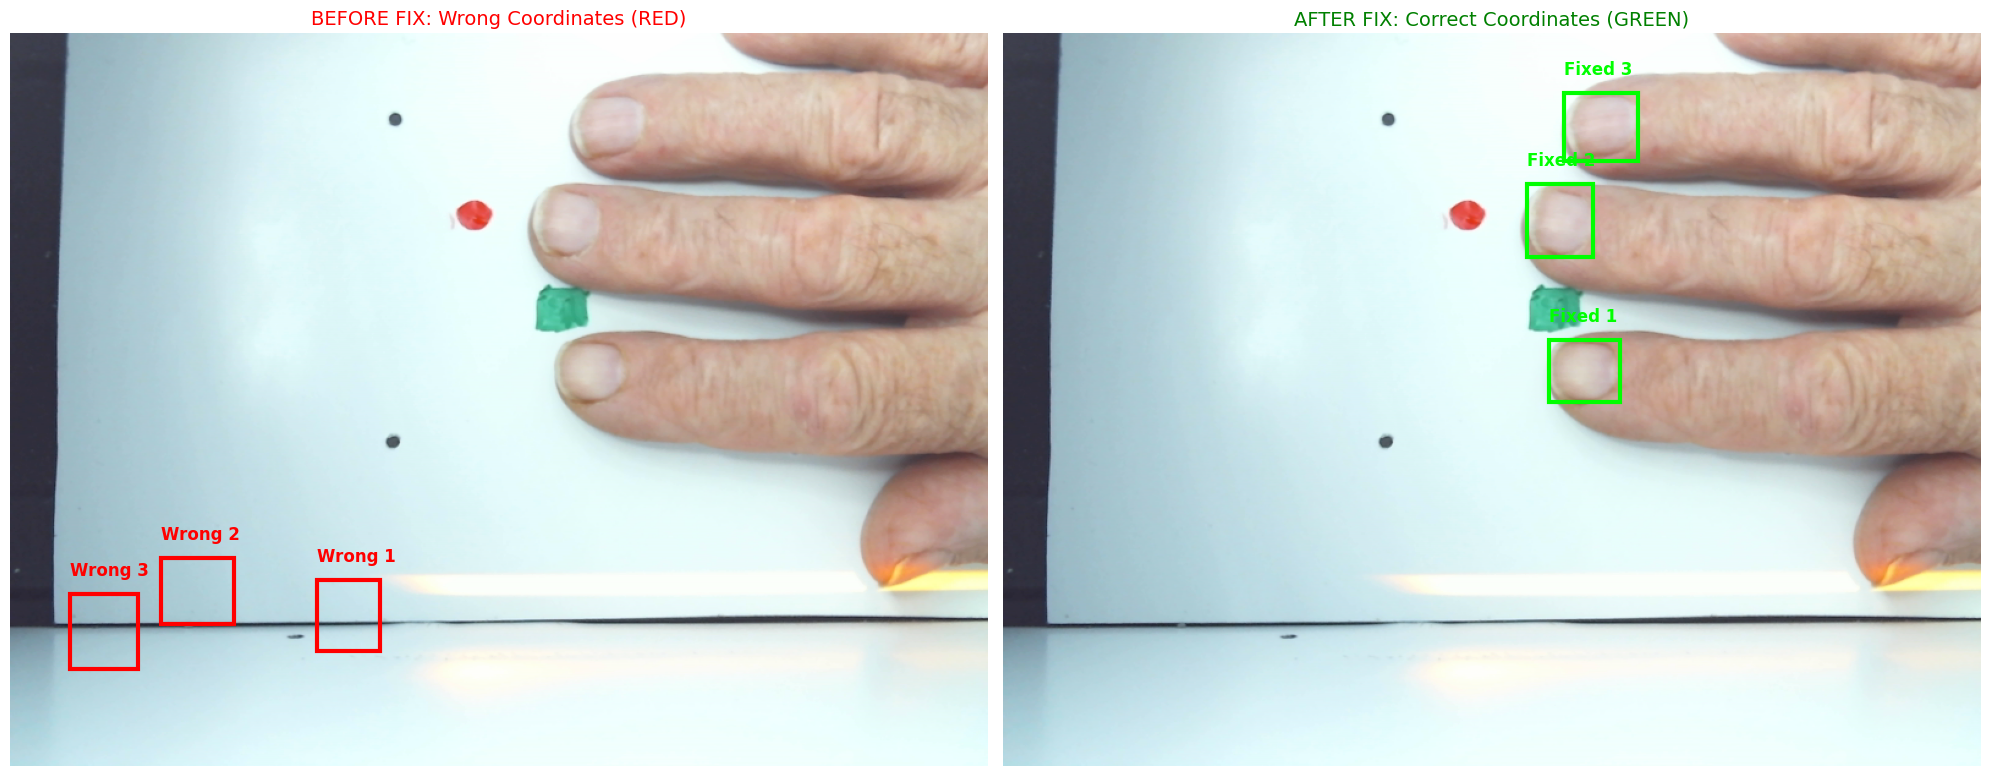

In [12]:
# VERIFICATION: Compare before and after coordinate fix
print("🔍 COORDINATE FIX VERIFICATION")
print("=" * 60)

# Original coordinates from CSV (swapped format)
sample_row = metadata.iloc[0]
original_boxes = ast.literal_eval(sample_row['NAIL_BOUNDING_BOXES'])
print(f"ORIGINAL (CSV): {original_boxes}")
print("Format: [y1, x1, y2, x2] - SWAPPED")

# Corrected coordinates from dataset class
corrected_sample = corrected_dataset[0]
corrected_boxes = corrected_sample[1]['boxes'].numpy()
print(f"\nCORRECTED (Dataset): {corrected_boxes.tolist()}")
print("Format: [x1, y1, x2, y2] - STANDARD")

print(f"\n📊 TRANSFORMATION VERIFICATION:")
for i, (orig, corr) in enumerate(zip(original_boxes, corrected_boxes)):
    y1, x1, y2, x2 = orig  # Original swapped format
    cx1, cy1, cx2, cy2 = corr  # Corrected standard format
    
    print(f"Box {i+1}:")
    print(f"  Original: [y1={y1}, x1={x1}, y2={y2}, x2={x2}]")
    print(f"  Corrected: [x1={cx1}, y1={cy1}, x2={cx2}, y2={cy2}]")
    
    # Verify the transformation is correct
    if x1 == cx1 and y1 == cy1 and x2 == cx2 and y2 == cy2:
        print(f"  ✅ Transformation CORRECT!")
    else:
        print(f"  ❌ Transformation ERROR!")

print(f"\n🎯 IMPACT ON TRAINING:")
print("✅ Model will now train on CORRECT nail locations")
print("✅ Bounding box predictions will align with actual nails")
print("✅ Performance metrics (IoU, mAP) should improve significantly")

# Side-by-side comparison visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Load original image
img_path = f"data/photo/{sample_row['PATIENT_ID']}.jpg"
original_img = Image.open(img_path).convert('RGB')

# Left: Original (wrong) coordinates
ax1.imshow(original_img)
ax1.set_title("BEFORE FIX: Wrong Coordinates (RED)", fontsize=14, color='red')
for i, box in enumerate(original_boxes):
    x1, y1, x2, y2 = box  # Using as-is (wrong)
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                           linewidth=3, edgecolor='red', facecolor='none')
    ax1.add_patch(rect)
    ax1.text(x1, y1-15, f'Wrong {i+1}', color='red', fontsize=12, weight='bold')

# Right: Corrected coordinates
ax2.imshow(original_img)
ax2.set_title("AFTER FIX: Correct Coordinates (GREEN)", fontsize=14, color='green')
for i, box in enumerate(corrected_boxes):
    x1, y1, x2, y2 = box
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                           linewidth=3, edgecolor='lime', facecolor='none')
    ax2.add_patch(rect)
    ax2.text(x1, y1-15, f'Fixed {i+1}', color='lime', fontsize=12, weight='bold')

for ax in [ax1, ax2]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [13]:
# Custom collate function for DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=4,  # Smaller batch size for object detection
    shuffle=True, 
    collate_fn=collate_fn,
    num_workers=0  # Set to 0 to avoid multiprocessing issues
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=4, 
    shuffle=False, 
    collate_fn=collate_fn,
    num_workers=0
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Training batches: 50
Validation batches: 13


In [14]:
# Create Faster R-CNN model for nail detection
def get_nail_detection_model(num_classes=2):  # Background + nail
    # Load pre-trained Faster R-CNN model
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

# Create model
model = get_nail_detection_model(num_classes=2)  # Background + nail
model.to(device)

print("Faster R-CNN model created for nail detection")
print(f"Model moved to: {device}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Faster R-CNN model created for nail detection
Model moved to: cuda
Total parameters: 41,299,161
Trainable parameters: 41,076,761


In [15]:
# Set up optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

print("Optimizer and scheduler initialized")
print(f"Initial learning rate: {optimizer.param_groups[0]['lr']}")

Optimizer and scheduler initialized
Initial learning rate: 0.005


In [16]:
# Training function
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    total_loss = 0
    num_batches = 0
    
    for batch_idx, (images, targets) in enumerate(data_loader):
        # Move to device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        total_loss += losses.item()
        num_batches += 1
        
        # Print progress
        if batch_idx % 10 == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}/{len(data_loader)}, Loss: {losses.item():.4f}")
    
    return total_loss / num_batches

# Validation function
def evaluate_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    num_batches = 0
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Set model to train mode for loss calculation
            model.train()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            total_loss += losses.item()
            num_batches += 1
    
    model.eval()  # Set back to eval mode
    return total_loss / num_batches

print("Training and evaluation functions defined")

Training and evaluation functions defined


In [ ]:
# Training loop
num_epochs = 10
best_val_loss = float('inf')
train_losses = []
val_losses = []
learning_rates = []

print(f"Starting training for {num_epochs} epochs...")
print("=" * 60)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print("-" * 30)
    
    # Training
    train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch + 1)
    
    # Validation
    val_loss = evaluate_model(model, val_loader, device)
    
    # Update learning rate
    lr_scheduler.step()
    
    # Record metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    learning_rates.append(optimizer.param_groups[0]['lr'])
    
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_nail_detection_model.pth')
        print(f"✅ New best model saved! (Val Loss: {val_loss:.4f})")
    else:
        print(f"📊 No improvement (Best: {best_val_loss:.4f})")

print("\n🎉 Training completed!")
print(f"Best validation loss: {best_val_loss:.4f}")

Starting training for 10 epochs...

Epoch 1/10
------------------------------
Epoch 1, Batch 0/50, Loss: 0.8954
Epoch 1, Batch 10/50, Loss: 0.4019
Epoch 1, Batch 20/50, Loss: 0.2916
Epoch 1, Batch 30/50, Loss: 0.2725
Epoch 1, Batch 40/50, Loss: 0.3049
Train Loss: 0.3725
Val Loss: 0.3289
Learning Rate: 0.005000
✅ New best model saved! (Val Loss: 0.3289)

Epoch 2/10
------------------------------
Epoch 2, Batch 0/50, Loss: 0.2647


In [ ]:
# Plot training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot losses
epochs_range = range(1, len(train_losses) + 1)
ax1.plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2)
ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot learning rate
ax2.plot(epochs_range, learning_rates, 'g-', label='Learning Rate', linewidth=2)
ax2.set_title('Learning Rate Schedule')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Learning Rate')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('nail_detection_training_progress.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training progress saved as 'nail_detection_training_progress.png'")

In [ ]:
# Evaluation and prediction function
def predict_nails(model, image_path, confidence_threshold=0.5):
    """Predict nail bounding boxes in an image"""
    model.eval()
    
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        predictions = model(image_tensor)
    
    # Extract predictions
    pred = predictions[0]
    boxes = pred['boxes'].cpu().numpy()
    scores = pred['scores'].cpu().numpy()
    labels = pred['labels'].cpu().numpy()
    
    # Filter by confidence threshold
    mask = scores >= confidence_threshold
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]
    
    return image, boxes, scores, labels

def visualize_predictions(image, boxes, scores, labels, title="Nail Detection Results"):
    """Visualize predictions on image"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(image)
    
    for box, score, label in zip(boxes, scores, labels):
        if label == 1:  # Nail class
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                   linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1-10, f'Nail: {score:.2f}', 
                   fontsize=10, color='lime', weight='bold',
                   bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
    
    ax.set_title(f"{title} - {len([l for l in labels if l == 1])} nails detected")
    ax.axis('off')
    plt.tight_layout()
    plt.show()

print("Prediction and visualization functions defined")

In [ ]:
# Test the trained model on validation samples
model.load_state_dict(torch.load('best_nail_detection_model.pth'))
model.eval()

print("Testing nail detection model on validation samples:")
print("=" * 60)

# Get some sample images from validation set
sample_indices = [0, 5, 10, 15, 20]

for i, idx in enumerate(sample_indices):
    # Get the actual dataset index from validation set
    actual_idx = val_dataset.indices[idx]
    row = metadata.iloc[actual_idx]
    img_path = os.path.join('data/photo', f"{row['PATIENT_ID']}.jpg")
    
    # Predict nails
    image, boxes, scores, labels = predict_nails(model, img_path, confidence_threshold=0.5)
    
    # Visualize results
    visualize_predictions(image, boxes, scores, labels, 
                         title=f"Sample {i+1} - Patient {row['PATIENT_ID']}")
    
    # Print detection summary
    nail_count = len([l for l in labels if l == 1])
    actual_boxes = ast.literal_eval(row['NAIL_BOUNDING_BOXES'])
    print(f"Sample {i+1}: Detected {nail_count} nails, Actual: {len(actual_boxes)} nails")
    if len(scores) > 0:
        print(f"  Confidence scores: {scores[labels == 1][:3]}...")  # Show first 3 scores
    print()

In [ ]:
# Calculate evaluation metrics
def calculate_iou(box1, box2):
    """Calculate Intersection over Union (IoU) between two boxes"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    if x2 <= x1 or y2 <= y1:
        return 0.0
    
    intersection = (x2 - x1) * (y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection
    
    return intersection / union if union > 0 else 0.0

def evaluate_detection_performance(model, val_dataset, metadata, iou_threshold=0.5, conf_threshold=0.5):
    """Evaluate nail detection performance"""
    model.eval()
    
    total_predictions = 0
    total_ground_truth = 0
    total_matches = 0
    
    print("Evaluating detection performance...")
    
    for i in range(min(50, len(val_dataset))):  # Evaluate on first 50 samples
        actual_idx = val_dataset.indices[i]
        row = metadata.iloc[actual_idx]
        img_path = os.path.join('data/photo', f"{row['PATIENT_ID']}.jpg")
        
        # Get predictions
        _, pred_boxes, scores, labels = predict_nails(model, img_path, conf_threshold)
        pred_boxes = pred_boxes[labels == 1]  # Only nail predictions
        
        # Get ground truth
        gt_boxes = ast.literal_eval(row['NAIL_BOUNDING_BOXES'])
        
        # Count matches
        matches = 0
        for pred_box in pred_boxes:
            for gt_box in gt_boxes:
                if calculate_iou(pred_box, gt_box) >= iou_threshold:
                    matches += 1
                    break
        
        total_predictions += len(pred_boxes)
        total_ground_truth += len(gt_boxes)
        total_matches += matches
    
    # Calculate metrics
    precision = total_matches / total_predictions if total_predictions > 0 else 0
    recall = total_matches / total_ground_truth if total_ground_truth > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1_score, total_predictions, total_ground_truth, total_matches

# Evaluate the model
precision, recall, f1, total_pred, total_gt, total_match = evaluate_detection_performance(
    model, val_dataset, metadata
)

print("\n🎯 NAIL DETECTION PERFORMANCE METRICS:")
print("=" * 50)
print(f"Precision: {precision:.3f} ({total_match}/{total_pred})")
print(f"Recall: {recall:.3f} ({total_match}/{total_gt})")
print(f"F1-Score: {f1:.3f}")
print(f"\nTotal predictions: {total_pred}")
print(f"Total ground truth: {total_gt}")
print(f"Total matches (IoU >= 0.5): {total_match}")

In [ ]:
# Save the final model with metadata
model_info = {
    "model_name": "FasterRCNN_Nail_Detector",
    "model_type": "object_detection",
    "architecture": "Faster R-CNN with ResNet50-FPN backbone",
    "training_date": datetime.now().isoformat(),
    "task": "nail_detection_in_finger_images",
    
    # Performance metrics
    "performance": {
        "precision": float(precision),
        "recall": float(recall),
        "f1_score": float(f1),
        "best_val_loss": float(best_val_loss)
    },
    
    # Training details
    "training": {
        "epochs": num_epochs,
        "batch_size": 4,
        "learning_rate": 0.005,
        "optimizer": "SGD",
        "scheduler": "StepLR",
        "device": str(device)
    },
    
    # Dataset information
    "dataset": {
        "total_samples": len(full_dataset),
        "train_samples": len(train_dataset),
        "val_samples": len(val_dataset),
        "num_classes": 2,  # Background + nail
        "class_names": ["background", "nail"]
    },
    
    # Model specifications
    "model_specs": {
        "input_format": "RGB images (any size)",
        "output_format": "Bounding boxes with confidence scores",
        "confidence_threshold": 0.5,
        "nms_threshold": 0.5
    }
}

# Save complete model
torch.save({
    'model_state_dict': model.state_dict(),
    'model_info': model_info,
    'training_history': {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'learning_rates': learning_rates
    }
}, 'nail_detection_model_final.pth')

# Save metadata
with open('nail_detection_model_metadata.json', 'w') as f:
    json.dump(model_info, f, indent=2)

print("✅ NAIL DETECTION MODEL SAVED SUCCESSFULLY!")
print("\n📁 Files created:")
print("  🎯 nail_detection_model_final.pth - Complete model")
print("  📋 nail_detection_model_metadata.json - Model information")
print("  📊 nail_detection_training_progress.png - Training plots")

print(f"\n🎉 TRAINING COMPLETED SUCCESSFULLY!")
print(f"  • Precision: {precision:.3f}")
print(f"  • Recall: {recall:.3f}")
print(f"  • F1-Score: {f1:.3f}")
print(f"  • Best validation loss: {best_val_loss:.4f}")

In [ ]:
# Create deployment code for the nail detection model
deployment_code = f'''# NAIL DETECTION MODEL - DEPLOYMENT CODE
# Copy this code to use the trained nail detection model in production

import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the trained model
def load_nail_detection_model(model_path, device='cpu'):
    """Load the trained nail detection model"""
    # Create model architecture
    model = fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)  # 2 classes
    
    # Load trained weights
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    return model

# Prediction function
def detect_nails(model, image_path, confidence_threshold=0.5, device='cpu'):
    """Detect nails in an image and return bounding boxes
    
    Args:
        model: Trained nail detection model
        image_path: Path to input image
        confidence_threshold: Minimum confidence for detections
        device: Device to run inference on
    
    Returns:
        dict: Dictionary containing:
            - 'boxes': List of bounding boxes [x1, y1, x2, y2]
            - 'scores': List of confidence scores
            - 'image': Original PIL image
    """
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        predictions = model(image_tensor)
    
    # Extract predictions
    pred = predictions[0]
    boxes = pred['boxes'].cpu().numpy()
    scores = pred['scores'].cpu().numpy()
    labels = pred['labels'].cpu().numpy()
    
    # Filter by confidence and nail class (label == 1)
    nail_mask = (scores >= confidence_threshold) & (labels == 1)
    nail_boxes = boxes[nail_mask].tolist()
    nail_scores = scores[nail_mask].tolist()
    
    return {{
        'boxes': nail_boxes,
        'scores': nail_scores,
        'image': image,
        'num_nails': len(nail_boxes)
    }}

# Visualization function
def visualize_nail_detection(result, title="Nail Detection"):
    """Visualize nail detection results"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(result['image'])
    
    for box, score in zip(result['boxes'], result['scores']):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                               linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1-10, f'Nail: {{score:.2f}}', 
               fontsize=10, color='lime', weight='bold',
               bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
    
    ax.set_title(f"{{title}} - {{result['num_nails']}} nails detected")
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
if __name__ == "__main__":
    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = load_nail_detection_model('nail_detection_model_final.pth', device)
    
    # Detect nails in an image
    result = detect_nails(model, 'path/to/your/image.jpg', 
                         confidence_threshold=0.5, device=device)
    
    # Print results
    print(f"Detected {{result['num_nails']}} nails")
    for i, (box, score) in enumerate(zip(result['boxes'], result['scores'])):
        print(f"Nail {{i+1}}: Box={{box}}, Confidence={{score:.3f}}")
    
    # Visualize results
    visualize_nail_detection(result)
'''

# Save deployment code
with open('nail_detection_deployment.py', 'w') as f:
    f.write(deployment_code)

print("\n📄 Deployment code saved as 'nail_detection_deployment.py'")
print("\n🚀 MODEL READY FOR DEPLOYMENT!")
print("  • Input: RGB finger images (any size)")
print("  • Output: Nail bounding boxes with confidence scores")
print("  • Use nail_detection_deployment.py for production")